# Milestone Project 1: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatiable with mixed precsion training. 

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible) 

Knowing this, in order to use mixed precision training we need access to a Tesla T4 (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+. 

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-63282212-06b9-7577-cd11-cfa4af1d7ab8)


## Get helper functions 

In past modules, we've created a bunch of helper functiosn to do small tasks required for our notebooks. 
Rather than rewrite all of these, we can import a script and load them in from there. 

The script we've got available can be found on Github

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-08-03 14:35:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-08-03 14:35:04 (102 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import series of helpful functions 
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

If you want to get an overview of TensorFlow Datasets (TFDS) read the guide on google.

In [ ]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [ ]:
# List all available datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [ ]:
# Load in the data 
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised =True, 
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete71WOL2/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete71WOL2/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from the dataset

To become one with our data we want to find:
* Class names
* the shape of our input data 
* the datatype of our input data
* what the labels look like (e.g. are they one hot encoded or are they label encode?)
* Do the labels match with the class names 

In [ ]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [ ]:
# Get the class names 
class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
# Take one sample of the data 
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
# Output info about our training sample 
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form) : {class_names[label.numpy()]}
  """)


  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 70
  Class name (str form) : pad_thai
  


In [ ]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[230, 229, 183],
        [231, 230, 184],
        [232, 231, 183],
        ...,
        [232, 233, 202],
        [229, 234, 204],
        [229, 236, 205]],

       [[228, 227, 179],
        [227, 226, 178],
        [226, 226, 176],
        ...,
        [234, 235, 204],
        [232, 237, 207],
        [234, 241, 210]],

       [[229, 229, 175],
        [229, 229, 175],
        [227, 227, 175],
        ...,
        [233, 234, 202],
        [232, 237, 205],
        [235, 242, 209]],

       ...,

       [[119,  97,  58],
        [131, 109,  70],
        [131, 109,  70],
        ...,
        [239, 241, 220],
        [238, 240, 219],
        [238, 240, 219]],

       [[120,  98,  61],
        [133, 111,  74],
        [135, 113,  76],
        ...,
        [240, 242, 221],
        [240, 242, 221],
        [240, 242, 221]],

       [[136, 114,  77],
        [135, 113,  76],
        [129, 107,  70],
        ...,
        [243, 245, 22

In [ ]:
# what are the min and max values of our image tensor 
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

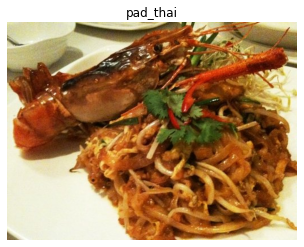

In [ ]:
# Plot an image tensor 
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

## Create preprocessing functions for our data

Neural networks perform best when data is in a certain way 
* batched
* normalized 
* etc.

However, not all data (including data from the TensorFlow Datasets) comes like this. 

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data.

What we know about our data:
* In `unit8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like: 
* Data in `float32` dataype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the image size to be the same size
* Scaled to values between 0 & 1 

With these points in mind, we've got a few things we can tackle with a preprocessing function.

This means our function needs to:
1. Reshape our images to all the same size 
2. convert the dtype of our image tensors from `unit8` to `float32`

In [ ]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
  """
  Converts image datatype from `uunit8` -> `float32` and reshape 
  image to [img_shape, img_shape, color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  #image = image/255. # not required for efficeintnetb0 as it has it inbuilt
  return tf.cast(image, tf.float32), label # return a tuuple of (float32_image, label)


In [ ]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f" Image before preprocessing:\n {image[:2]}. \nShape: {image.shape}, \nDatatype: {image.dtype}\n")
print(f" Image after preprocessing: \n {preprocessed_img[:2]}. \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}\n")

 Image before preprocessing:
 [[[230 229 183]
  [231 230 184]
  [232 231 183]
  ...
  [232 233 202]
  [229 234 204]
  [229 236 205]]

 [[228 227 179]
  [227 226 178]
  [226 226 176]
  ...
  [234 235 204]
  [232 237 207]
  [234 241 210]]]. 
Shape: (384, 512, 3), 
Datatype: <dtype: 'uint8'>

 Image after preprocessing: 
 [[[229.46939 228.46939 181.7551 ]
  [229.59184 228.94897 180.2347 ]
  [224.14796 224.14796 171.71939]
  ...
  [238.21933 231.07143 200.37251]
  [237.02545 233.38266 204.23978]
  [230.32655 236.04091 205.68373]]

 [[228.80103 228.87245 174.58673]
  [225.95409 225.95918 173.80103]
  [226.64795 226.64795 174.21939]
  ...
  [238.41322 232.41322 199.95409]
  [235.8571  233.14287 202.07143]
  [233.04602 238.76038 206.4032 ]]]. 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>



## Batch & prepare datasets 
 
 we're now going to make out data input pipeline run really fast. 

 For more information on this refer to : https://www.tensorflow.org/guide/data_performance

In [ ]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func =preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
#Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data 
test_data = test_data.map(map_func =preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks 

we're going to create a couple callbacks to help us while our model trains 
* TensorBoard callback to log training results (so we can visualzie them later if need be) 
* ModelCheckpoint callback to save our model's progress after feature extraction

In [ ]:
# Create tensorboard callback (import from helper_functions)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training 
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor = 'val_accuracy',
                                                      save_best_only = True, 
                                                      save_weights_only = True,
                                                      verbose = 0)

## Setup mixed precision training 

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance. 

In [ ]:
from tensorflow.keras import mixed_precision 
mixed_precision.set_global_policy('mixed_float16') 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


## Build feature extraction model 

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer')
# Note: EfficientNetBX models have rescaling built-in but if your model doesn't, you can use something like below
# x = preprocessing.Rescaling(1./255)
x = base_model(inputs, training = False) # make sure layers which should be in inference mode only stay like that 
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype = tf.float32, name = "softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Check the dytpe of each layer 
for layer in model.layers:
  print(f"Layer name: {layer.name} \nLayer trainable: {layer.trainable} \nLayer dtype:{layer.dtype} \nLayer policy: {layer.dtype_policy}")

Layer name: input_layer 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: efficientnetb0 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: global_average_pooling2d 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: dense 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: softmax_float32 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer 
* `layer.trainable` : is the layer trainable or not? (if `False` the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in 
* `layer.dtype_policy`: the data type policy a layer computes on its variables with

In [ ]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of base model)
  print(f"Layer name: {layer.name} \nLayer trainable: {layer.trainable} \nLayer dtype:{layer.dtype} \nLayer policy: {layer.dtype_policy}")

Layer name: input_1 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: rescaling 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: normalization 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_conv_pad 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_conv 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_bn 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_activation 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_dwconv 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_bn 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_activat

## Fit the feature extraction model 

If our goal is to fine-tune a pretrained model, the general order of doing things is: 
1. Build a feature extraction model (train a couple output layers with base layers frozen )
2. Fine-tune some of the frozen layers

In [ ]:
# Fit the feature extraction model with callbacks 
history_101_food_classses_feature_extract = model.fit(train_data,
                                                      epochs = 3,
                                                      steps_per_epoch = (len(train_data)),
                                                      validation_data = test_data,
                                                      validation_steps = int(0.15 * len(test_data)),
                                                      callbacks = [create_tensorboard_callback(dir_name="training_logs",
                                                                                               experiment_name ="efficientnetb0_101_classes_all_data_feature_extract"), 
                                                                   model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20220803-145857
Epoch 1/3
2368/2368 [==============================] - 178s 74ms/step - loss: 1.0449 - accuracy: 0.7274 - val_loss: 1.0756 - val_accuracy: 0.7100
Epoch 2/3
2368/2368 [==============================] - 181s 75ms/step - loss: 0.9732 - accuracy: 0.7439 - val_loss: 1.0596 - val_accuracy: 0.7121
Epoch 3/3
2368/2368 [==============================] - 163s 68ms/step - loss: 0.9143 - accuracy: 0.7599 - val_loss: 1.0555 - val_accuracy: 0.7182


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 62ms/step - loss: 1.0668 - accuracy: 0.7102


[1.0667647123336792, 0.7101781964302063]

## Off to you...

 We've covered a lot of ground so far but since this is a milestone project, it's time for you to takeover.

 More specifically, you're challenge is to complete the [TEMPLATE version of 07](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/TEMPLATE_07_food_vision_milestone_project_1.ipynb) to obtain a computer vision model (building off the one we've built in this notebook) to beat the DeepFood paper. 

 In other words, you are going to create Food Vision Big. 

## TODO: Save the model to file

In [ ]:
# Save model locally 
model.save("drive/My Drive/Personal Projects/TensorFlow Cert/07_milestone_project_1_101_food_classes_feature_extraction")

INFO:tensorflow:Assets written to: drive/My Drive/Personal Projects/TensorFlow Cert/07_milestone_project_1_101_food_classes_feature_extraction/assets


INFO:tensorflow:Assets written to: drive/My Drive/Personal Projects/TensorFlow Cert/07_milestone_project_1_101_food_classes_feature_extraction/assets


In [ ]:
# Load model previously saved above 
loaded_model = tf.keras.models.load_model("drive/My Drive/Personal Projects/TensorFlow Cert/07_milestone_project_1_101_food_classes_feature_extraction")

In [ ]:
# Check the dtype_policy attributes of layers in the loaded model
for layer in loaded_model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of base model)
  print(f"Layer name: {layer.name} \nLayer trainable: {layer.trainable} \nLayer dtype:{layer.dtype} \nLayer policy: {layer.dtype_policy}")

Layer name: input_1 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: rescaling 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: normalization 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_conv_pad 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_conv 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_bn 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_activation 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_dwconv 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_bn 
Layer trainable: False 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_activat

In [ ]:
# check loaded model performance
loaded_model_results = loaded_model.evaluate(test_data)

790/790 [==============================] - 55s 69ms/step - loss: 1.0668 - accuracy: 0.7102


In [ ]:
import numpy as np
# Check to make sure loaded model performance is close to presaved model
np.isclose(loaded_model_results , results_feature_extract_model)

array([ True,  True])

## TODO: Preparing our model's layers for fine tuning 

 Utilize presaved model provided by course to ensure similar performance and same model

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip 

--2022-08-03 15:32:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.24.128, 142.250.4.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.24.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  39.5MB/s    in 0.4s    

2022-08-03 15:32:29 (39.5 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [ ]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate the downloaded GS model 
loaded_gs_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [ ]:
# Evaluate downloaded GS model
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)

790/790 [==============================] - 58s 68ms/step - loss: 1.0881 - accuracy: 0.7065


In [ ]:
# Get a summary of the downloaded model
loaded_gs_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Set all of the layers .trainable variable in the loaded model to True so they are unfrozen
loaded_gs_model.trainable = True

In [ ]:
# Check the dtype_policy attributes of layers in the loaded gs model
for layer in loaded_gs_model.layers[1].layers[:20]: # check the layers of the base model (layer at index 1 of base model)
  print(f"Layer name: {layer.name} \nLayer trainable: {layer.trainable} \nLayer dtype:{layer.dtype} \nLayer policy: {layer.dtype_policy}")

Layer name: input_1 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: rescaling 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: normalization 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "float32">
Layer name: stem_conv_pad 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_conv 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_bn 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: stem_activation 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_dwconv 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_bn 
Layer trainable: True 
Layer dtype:float32 
Layer policy: <Policy "mixed_float16">
Layer name: block1a_activation 
Layer trai

In [ ]:
# Set up earlystopping callback to prevent over training 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience =3)

# Set up model checkpoint 
model_checkpoint_path = "model_checkpoints/gs.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_checkpoint_path,
                                                      monitor = 'val_accuracy',
                                                      save_best_only = True, 
                                                      save_weights_only = True,
                                                      verbose = 0)

In [ ]:
# Compile the model for fine-tuning 
loaded_gs_model.compile(loss = 'sparse_categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4),
                        metrics = ['accuracy'])

In [ ]:
# Start fine-tuning
fine_tune_epochs = 100 
validation_amount = int(0.15 * len(test_data))

history_101_food_classses_fine_tuning = loaded_gs_model.fit(train_data, 
                                                            epochs = fine_tune_epochs,
                                                            validation_data = test_data,
                                                            validation_steps = validation_amount,
                                                            initial_epoch = history_101_food_classses_feature_extract.epoch[-1],
                                                            callbacks = [model_checkpoint, 
                                                                         early_stopping, 
                                                                         create_tensorboard_callback(dir_name='training_logs',
                                                                                                     experiment_name = 'Food_Vision_Big')])


Saving TensorBoard log files to: training_logs/Food_Vision_Big/20220803-155141
Epoch 3/100
2368/2368 [==============================] - 397s 159ms/step - loss: 0.9201 - accuracy: 0.7524 - val_loss: 0.7855 - val_accuracy: 0.7802
Epoch 4/100
2368/2368 [==============================] - 344s 144ms/step - loss: 0.5814 - accuracy: 0.8381 - val_loss: 0.7654 - val_accuracy: 0.7900
Epoch 5/100
2368/2368 [==============================] - 354s 149ms/step - loss: 0.3294 - accuracy: 0.9068 - val_loss: 0.8723 - val_accuracy: 0.7797
Epoch 6/100
2368/2368 [==============================] - 338s 142ms/step - loss: 0.1752 - accuracy: 0.9478 - val_loss: 0.9986 - val_accuracy: 0.7826
Epoch 7/100
2368/2368 [==============================] - 336s 141ms/step - loss: 0.1054 - accuracy: 0.9672 - val_loss: 1.0494 - val_accuracy: 0.7797


## TODO: View Training results on TensorBoard

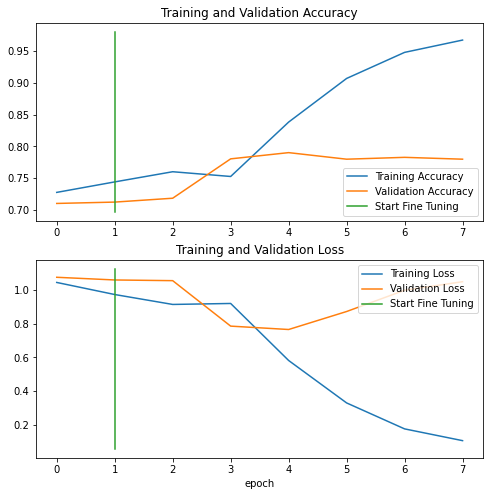

In [ ]:
# Compare histories of feature extract and fine tuning 
compare_historys(history_101_food_classses_feature_extract,
                 history_101_food_classses_fine_tuning, 
                 initial_epochs = history_101_food_classses_feature_extract.epoch[-1])

In [ ]:
# View tensorboard logs of models 
!tensorboard dev upload --logdir ./training_logs \
--name "Food Vision Big Experiments" \
--description "Two models evaluating Food101 image dataset using fine-tuning and feature extraction with mixed precision" \
--one_shot 


***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./training_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email&state=G63ETcsrhuldhkaEY2qi04ySql3ukW&prompt=consent&access_type=offli

## TODO: Evaluate your trained model 
Some ideas you might want to go through:

1. Find the precision, recall and f1 scores for each class (all 101).
2. Build a confusion matrix for each of the classes.
3. Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).


In [ ]:
# Make predictions with model
pred_probs = loaded_gs_model.predict(test_data, verbose=1) # set verbosity to see how long it will take 

790/790 [==============================] - 53s 65ms/step


In [ ]:
# Get the class predicitons of each label
pred_classes = pred_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]

array([38, 12, 34,  5, 10, 32, 96, 72, 63, 91])

In [ ]:
# get y true
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10] # check what they look like (unshuffled)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Find the precision, recall and f1 scores for each class
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       1.00      0.01      0.01     25250
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00         0
          17       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
from helper_functions import make_confusion_matrix
# Note: The following confusion matrix code is a remix of Scikit-Learn's 
# plot_confusion_matrix function - https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide


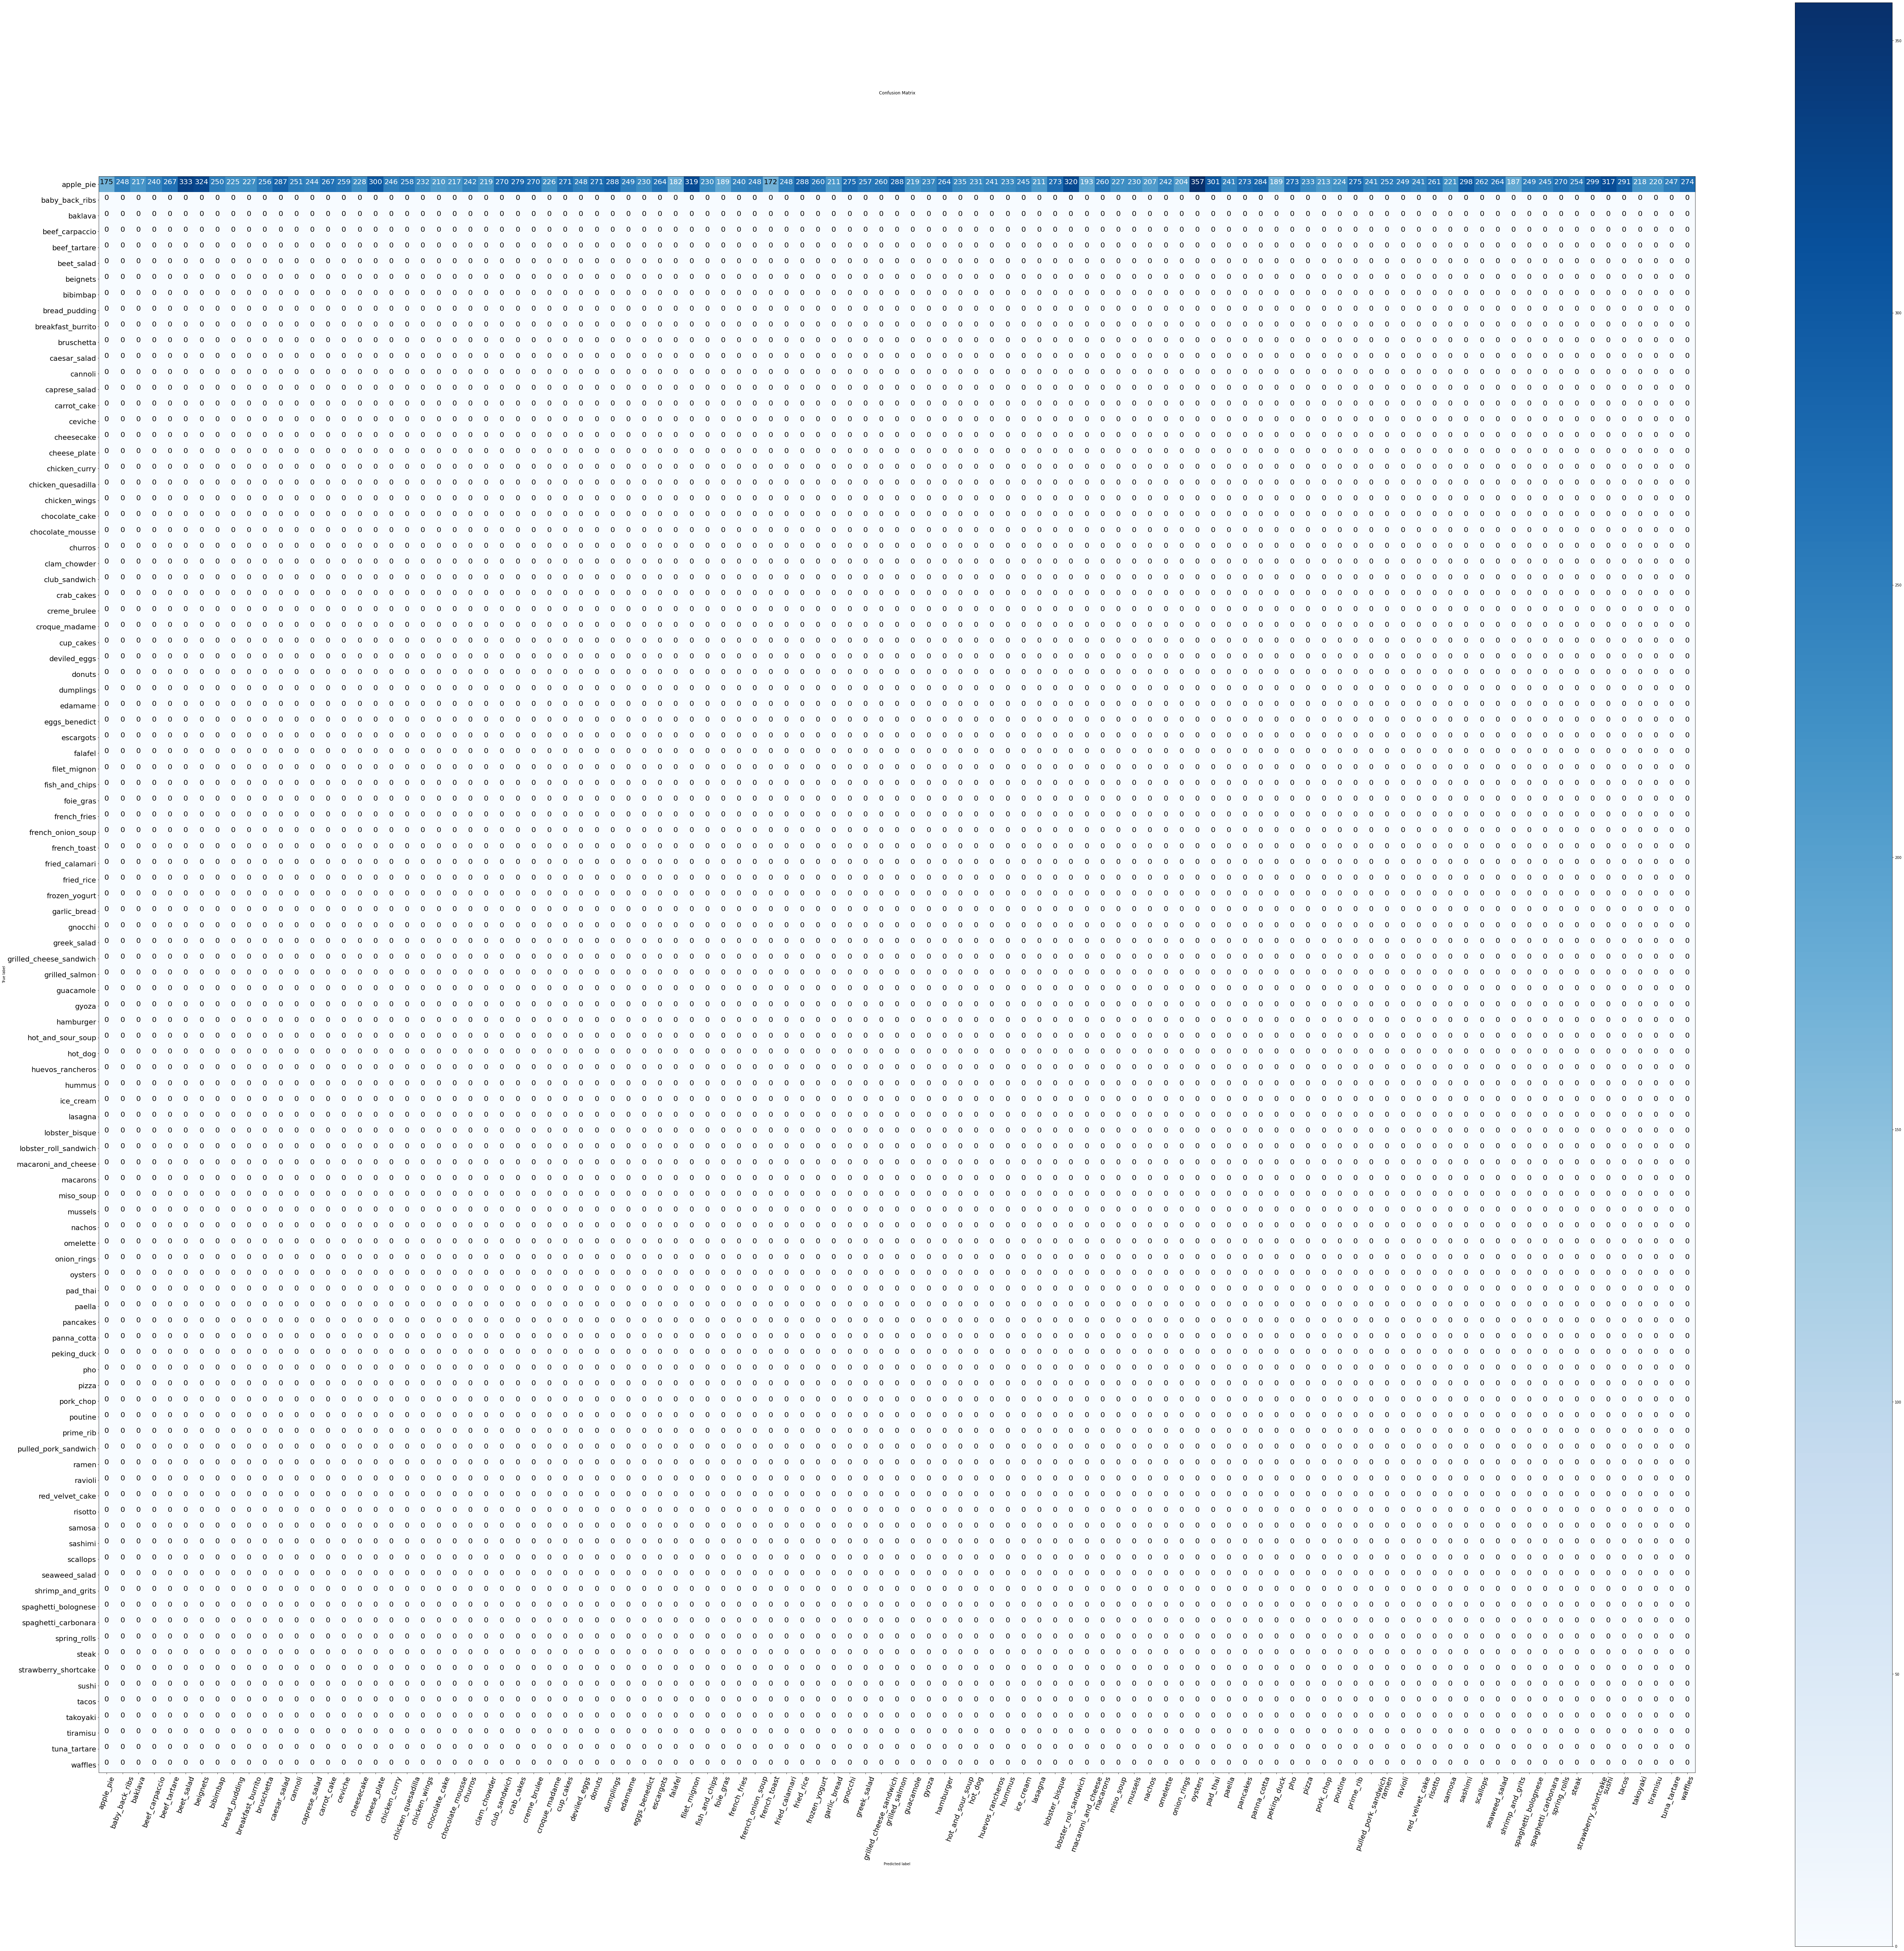

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)